# Visualize Nuclear availability and Simpson paradox

## Set up

In [1]:
import pandas as pd
import seaborn as sns
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from entsoe import mappings
from sklearn.linear_model import LinearRegression

from scripts.utils import scale_font_latex
from scripts.countries import ENERGY_CRISIS
%load_ext autoreload
%autoreload 2

In [2]:
# load data and set constants

END = pd.Timestamp("20231231T23", tz="utc")
START = pd.Timestamp("20180101T00", tz="utc")
years = f"{START.year}-{END.year}"

NEIGHBOURS = mappings.NEIGHBOURS
COUNTRY_CODE = "FR"

data = (
    pd.read_csv(
        f"../data/processed/combined_data/data_selected_{COUNTRY_CODE}_{years}.csv",
        parse_dates=["timestamp"],
    )
    .set_index("timestamp")
    .rename(columns={"nuclear_avail": "na", "ramperation_da": "gen_da_ramp"})
)
data = data.loc[:].dropna()

## Simpson's paradox

In [3]:
# functions used for plotting


def plot_na_full_variable(ax, start, end, x_data, y_data, y_label):
    """
    Plot price vs nuclear availability.

    Parameters:
    ax (matplotlib.axes.Axes): The axes to plot on.
    start (pd.Timestamp): Start timestamp for the data range.
    end (pd.Timestamp): End timestamp for the data range.
    x_data (pd.Series): Data for the x-axis (nuclear availability).
    y_data (pd.Series): Data for the y-axis (e.g., price or net exports).
    y_label (str): Label for the y-axis.

    Returns:
    None
    """
    df_x = x_data.loc[start:end]
    df_y = y_data.loc[start:end]

    # Linear fit:
    x_val = df_x.values.reshape((-1, 1)) / 1000  # Convert to GW
    y_val = df_y.values.reshape((-1, 1))
    linear_model = LinearRegression().fit(x_val, y_val)
    slope = linear_model.coef_[0][0]
    print(slope)

    c1 = "#bbbbbb"
    c2 = "black"
    ax.scatter(x_val, y_val, s=1, c=c1, label="data")
    ax.plot(
        x_val,
        linear_model.predict(x_val),
        color=c2,
        label=f"{slope:.4f} total",
        alpha=0.7,
        linewidth=2,
    )
    ax.set_ylabel(y_label)
    ax.set_xlabel("Available nuclear capacity (GW)")
    ax.margins(0, 0)


def plot_na_load(ax, start, end, load_bins, x_data, y_data, y_label):
    """
    Plot price or net exports vs nuclear availability. Data is divided into subsets according to load bins.

    Parameters:
    ax (matplotlib.axes.Axes): The axes to plot on.
    start (pd.Timestamp): Start timestamp for the data range.
    end (pd.Timestamp): End timestamp for the data range.
    load_bins (dict): Dictionary of load bins for grouping data.
    x_data (pd.Series): Data for the x-axis (nuclear availability).
    y_data (pd.Series): Data for the y-axis (e.g., price or net exports).
    y_label (str): Label for the y-axis.

    Returns:
    None
    """
    df_x = x_data.loc[start:end]
    df_y = y_data.loc[start:end]

    # Labeling
    labels = [
        rf"L $\in$ {round(bin[0] / 1000),round(bin[-1] / 1000)} GW" for bin in load_bins
    ]
    colors = sns.color_palette("colorblind")

    for i, bin in enumerate(load_bins):
        # Select only data that are in the bin.
        mask = data["load_da"].isin(bin)
        x_val = df_x[mask].values.reshape((-1, 1)) / 1000  # Convert to GW
        y_val = df_y[mask].values.reshape((-1, 1))

        if len(x_val) == 0:
            print(bin, " has no entry for nuclear availability")
            continue
        linear_model = LinearRegression().fit(x_val, y_val)
        slope = linear_model.coef_[0][0]
        print(slope)

        ax.scatter(x_val, y_val, s=1, color=colors[i])
        ax.plot(
            x_val,
            linear_model.predict(x_val),
            alpha=0.7,
            linewidth=1.5,
            color=colors[i],
            label=f"{slope:.2f} for {labels[i]}",
        )

        ax.set_xlabel("Available nuclear capacity (GW)")
        ax.set_ylabel(y_label)
        ax.margins(0, 0)

In [4]:
# load bins. only 2020 is used. bins where choosen such that load of each year is divided into 4 subsets
all_bins = {
    2015: [range(30000 + i * 15000, 30000 + 15000 * (i + 1)) for i in range(4)],
    2017: [range(25000 + i * 20000, 30000 + 20000 * (i + 1)) for i in range(4)],
    2019: [range(25000 + i * 15000, 25000 + 15000 * (i + 1)) for i in range(4)],
    2020: [range(25000 + i * 15000, 25000 + 15000 * (i + 1)) for i in range(4)],
}

## Price vs. Nuclear availability -simpsons paradox

0.446124510763649
-0.49759731599146234
-0.7307644420498544
-0.3912594022716995
-0.1638198872497848


C:\Users\s.schreyer\AppData\Local\Temp\ipykernel_22856\2815903212.py:90: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2)
c:\Users\s.schreyer\AppData\Local\miniforge3\envs\causal_inference_final\lib\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


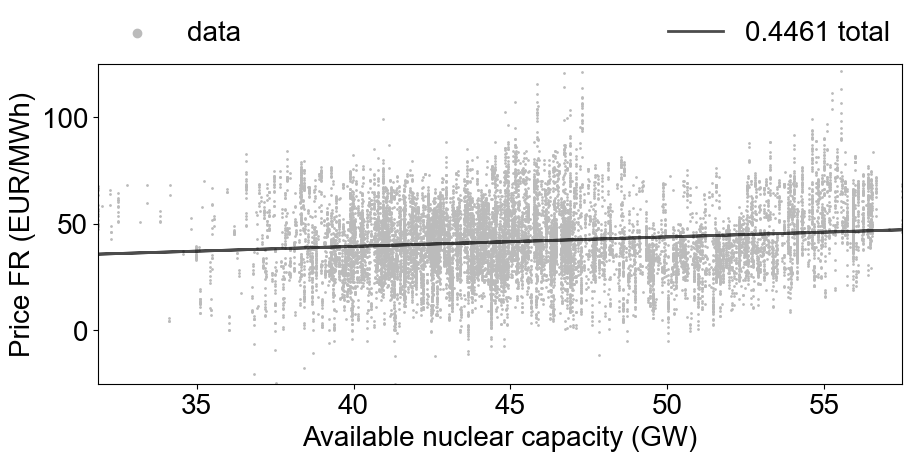

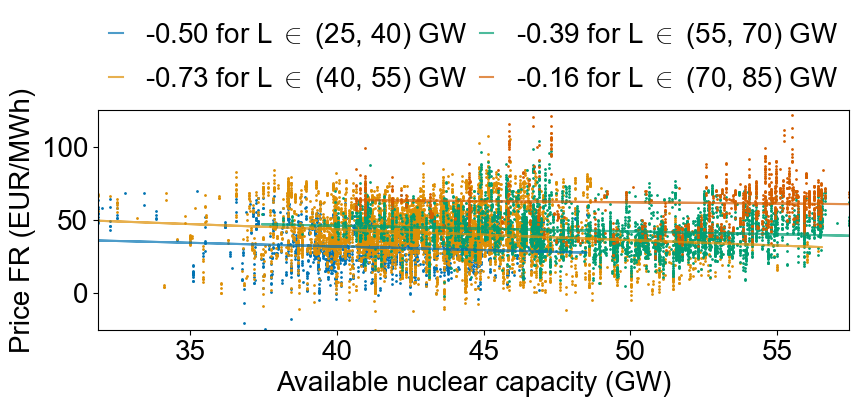

In [ ]:
fig_dir = "../reports/figures/simpsons_paradox/"
os.makedirs(fig_dir, exist_ok=True)
# example of simpsons paradox.  01.04.2018 - 01.04.2020



start = pd.Timestamp("20180401", tz="utc")


end = pd.Timestamp("20200401", tz="utc")



quarters = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

scale_font_latex(1)



fig_full, ax = plt.subplots(1, 1, figsize=(9, 4.5), layout="constrained")



ymax = 125


ymin = -25



# plot full data


plot_na_full_variable(
    start=start,
    end=end,
    ax=ax,

    x_data=data["na"],
    y_data=data["price_da"],

    y_label="Price FR (EUR/MWh)",
)
ax.set_ylim(ymax=ymax, ymin=ymin)
ax.legend(

    loc="lower left",
    markerscale=6,
    ncol=2,

    frameon=False,
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    mode="expand",
    borderaxespad=0.0,
)



fig_full.savefig(
    fig_dir
    + f"price_vs_na_{COUNTRY_CODE}_{start.month}-{start.year}-{end.month}-{end.year}_full.png",
    dpi=450,
)


# plot data grouped into subsets of similiar load


fig_subsets, ax = plt.subplots(1, 1, figsize=(9, 4.5), layout="constrained")


bins = all_bins[2020]

plot_na_load(
    start=start,
    end=end,
    load_bins=bins,
    ax=ax,

    x_data=data["na"],
    y_data=data["price_da"],

    y_label="Price FR (EUR/MWh)",
)
ax.set_ylim(ymax=ymax, ymin=ymin)
ax.legend(

    loc="lower left",
    handlelength=0.5,
    markerscale=6,
    ncol=2,

    frameon=False,
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    mode="expand",
    borderaxespad=0.0,
)



plt.tight_layout(h_pad=2)



fig_subsets.savefig(
    fig_dir

    + f"price_vs_na_{COUNTRY_CODE}_{start.month}-{start.year}-{end.month}-{end.year}_subsets.png",
    dpi=450,
)

# Net Exports vs. Nuclear availability - simpsons paradox

-0.0015415758927739712
0.6385961469436467
0.3889120298646376
0.4440029097716399
0.4827310469167167


C:\Users\s.schreyer\AppData\Local\Temp\ipykernel_22856\3765992366.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2)
c:\Users\s.schreyer\AppData\Local\miniforge3\envs\causal_inference_final\lib\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)


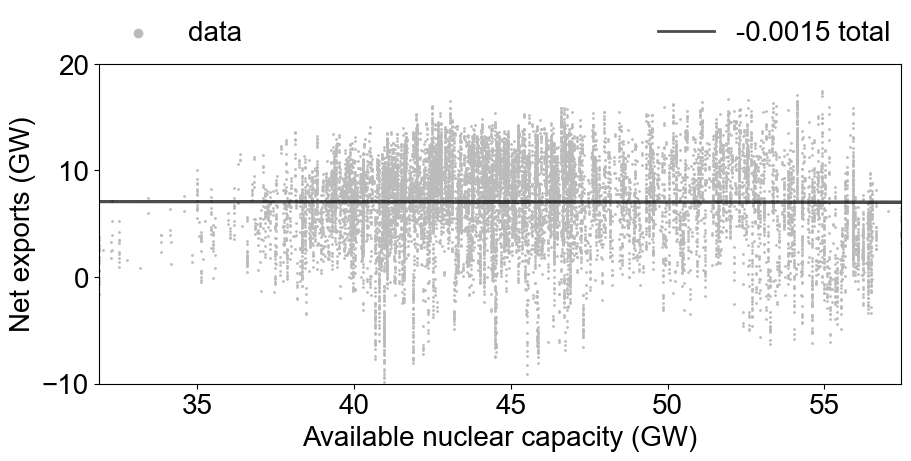

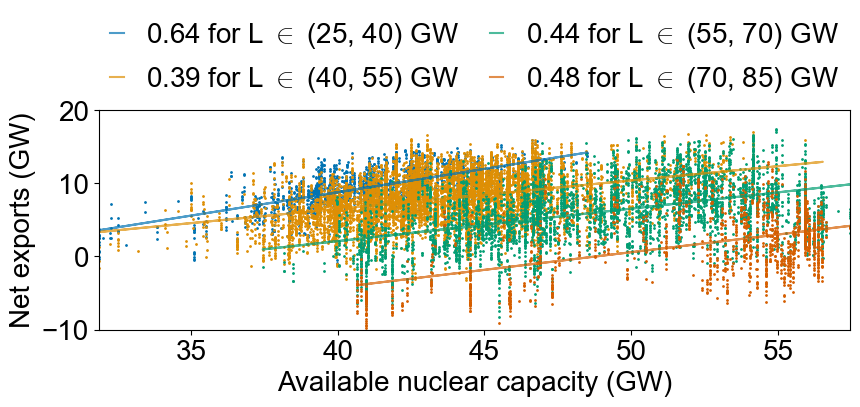

In [ ]:
fig_dir = "../reports/figures/simpsons_paradox/"
os.makedirs(fig_dir, exist_ok=True)

# simpsons paradox. 01.04.2018 - 01.04.2020


start = pd.Timestamp("20180401", tz="utc")


end = pd.Timestamp("20200401", tz="utc")



quarters = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]



scale_font_latex(1)


fig_full, ax = plt.subplots(1, 1, figsize=(9, 4.5), layout="constrained")


# Adjust layout to add space between subplots



ymax = 20


ymin = -10



# plot full data


plot_na_full_variable(
    start=start,
    end=end,
    ax=ax,

    x_data=data["na"],
    y_data=data["agg_net_export"] / 1000,

    y_label="Net exports (GW)",
)
ax.set_ylim(ymax=ymax, ymin=ymin)
ax.legend(

    loc="lower left",
    markerscale=6,
    ncol=2,
    frameon=False,

    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    mode="expand",
    borderaxespad=0.0,
)



fig_full.savefig(
    fig_dir
    + f"net_exports_vs_na_{COUNTRY_CODE}_{start.month}-{start.year}-{end.month}-{end.year}_full.png",
    dpi=450,
)



# plot data grouped into subsets of similiar load
fig_subsets, ax = plt.subplots(1, 1, figsize=(9, 4.5), layout="constrained")



bins = all_bins[2020]

plot_na_load(
    start=start,
    end=end,
    load_bins=bins,
    ax=ax,

    x_data=data["na"],
    y_data=data["agg_net_export"] / 1000,

    y_label="Net exports (GW)",
)
ax.set_ylim(ymax=ymax, ymin=ymin)
ax.legend(

    loc="lower left",
    handlelength=0.5,
    markerscale=6,
    ncol=2,
    frameon=False,

    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    mode="expand",
    borderaxespad=0.0,
)



plt.tight_layout(h_pad=2)


fig_subsets.savefig(
    fig_dir
    + f"net_exports_vs_na_{COUNTRY_CODE}_{start.month}-{start.year}-{end.month}-{end.year}_subsets.png",
    dpi=450,
)

### Seasonality of nuclear availability

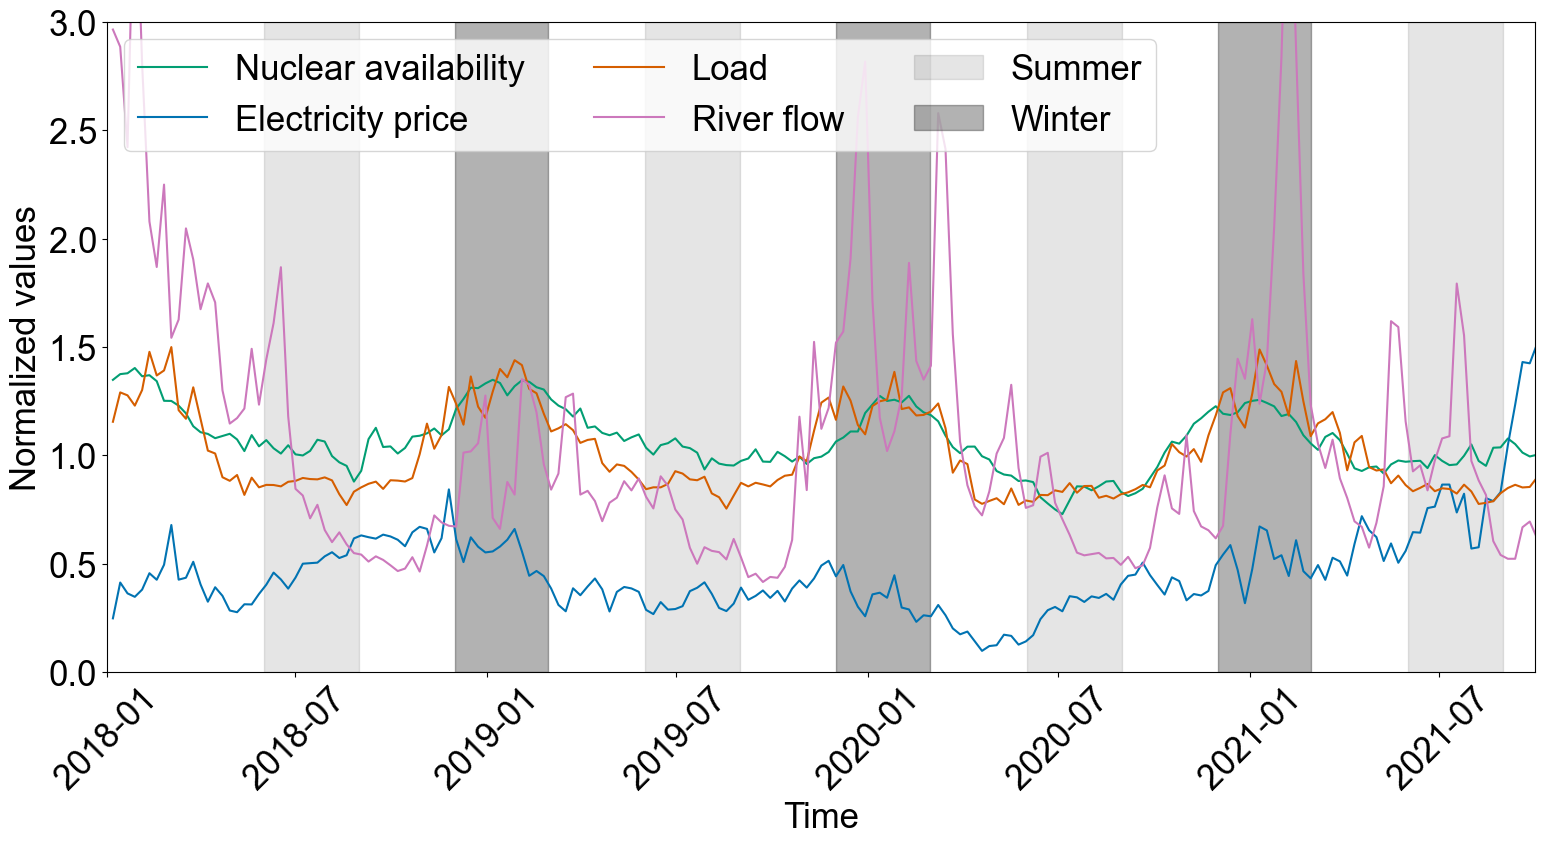

In [5]:
"""
Display the seasonality of nuclear availability, load and price.
"""

scale_font_latex(1.25)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))


# Set labels


data.index = pd.to_datetime(data.index)


ax.set_xlabel("Time")


ax.set_ylabel("Normalized values")


# plt.ylim(0, 200)

plt.plot(
    data.loc[:ENERGY_CRISIS, "na"].resample("1W").mean() / data["na"].mean(),
    label="Nuclear availability",
    color=sns.color_palette("colorblind")[2],
)
plt.plot(
    data.loc[:ENERGY_CRISIS, "price_da"].resample("1W").mean()
    / data["price_da"].mean(),
    label="Electricity price",
    color=sns.color_palette("colorblind")[0],
)
plt.plot(
    data.loc[:ENERGY_CRISIS, "load_da"].resample("1W").mean() / data["load_da"].mean(),
    label="Load",
    color=sns.color_palette("colorblind")[3],
)
plt.plot(
    data.loc[:ENERGY_CRISIS, "river_flow_mean"].resample("1W").mean()
    / data["river_flow_mean"].mean(),
    label="River flow",
    color=sns.color_palette("colorblind")[4],
)

ax.set_xlim(START, ENERGY_CRISIS)
years = sorted(
    set(pd.date_range(start=START, end=ENERGY_CRISIS, freq="D").year)
)  # Extract unique years

for year in years:

    # Define seasons

    summer_start = pd.Timestamp(f"{year}-06-01")

    summer_end = pd.Timestamp(f"{year}-08-31")

    winter_start = pd.Timestamp(f"{year}-12-01")

    winter_end = pd.Timestamp(f"{year+1}-03-01") - timedelta(
        days=1
    )  # Winter crosses into next year

    # Add hatching spans for seasons

    ax.fill_betweenx(
        y=[0, 3],
        x1=summer_start,
        x2=summer_end,
        color="black",
        alpha=0.1,
        label="Summer" if year == years[0] else "",
    )

    ax.fill_betweenx(
        y=[0, 3],
        x1=winter_start,
        x2=winter_end,
        color="black",
        alpha=0.3,
        label="Winter" if year == years[0] else "",
    )


plt.xticks(rotation=45)

plt.ylim(0, 3)

plt.legend(ncol=3, loc="upper left")

plt.tight_layout()

fig_dir = "../reports/figures/simpsons_paradox/"

os.makedirs(fig_dir, exist_ok=True)

fig.savefig(fig_dir + f"na_seasonality_{COUNTRY_CODE}.pdf")